# Tinker with the RNN

**NOTE: this is saved output from `fmda_rnn_Tinker` from December 2023. Some of these changes may be addressed in further versions of the model.**

The point of this notebook is to analyze the Physics-Initiated RNN on a granual scale. In each major section, we will present an issue with the RNN outputs and analyze ways to fix.

## Setup

In [1]:
# Setup
import reproducibility

# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
# from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
import pickle, os
from utils import hash2
%matplotlib inline

# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan, load_and_fix_data
from data_funcs import raws_data, synthetic_data, plot_data, check_data, rmse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import run_case, run_rnn, create_RNN_2, staircase, create_rnn_data, train_rnn, rnn_predict


C:\Users\jhirs\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
# Data
# Change directory for data read/write

dict_file='data/raws_CO_202306.pickle' # input path of FMDA dictionaries
reproducibility_file='data/reproducibility_dict.pickle'

# read test datasets
test_dict={}
test_dict.update(load_and_fix_data(dict_file))
print(test_dict.keys())

repro_dict={}
repro_dict.update(load_and_fix_data(reproducibility_file))
print(repro_dict.keys())

After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan

## Poor initial fits 

Sometimes the RNN has very poor initial fits. When the activation is linear, this results in largely overestimating the FM. We will examine whether this is an issue with the data or with fitting the initial weights.

* Case studies for overestimating: `CPTC2_202306010000`, `CHAC2_202306010000`, `CHRC2_202306010000`, `WLCC2_202306010000`

In [3]:
# Build Case Data
id = "CPTC2_202306010000"
case_data=test_dict[id]
case_data["hours"]=len(case_data['fm'])
case_data["h2"]=int(24*20)

First, we check how the Augmented KF performs.

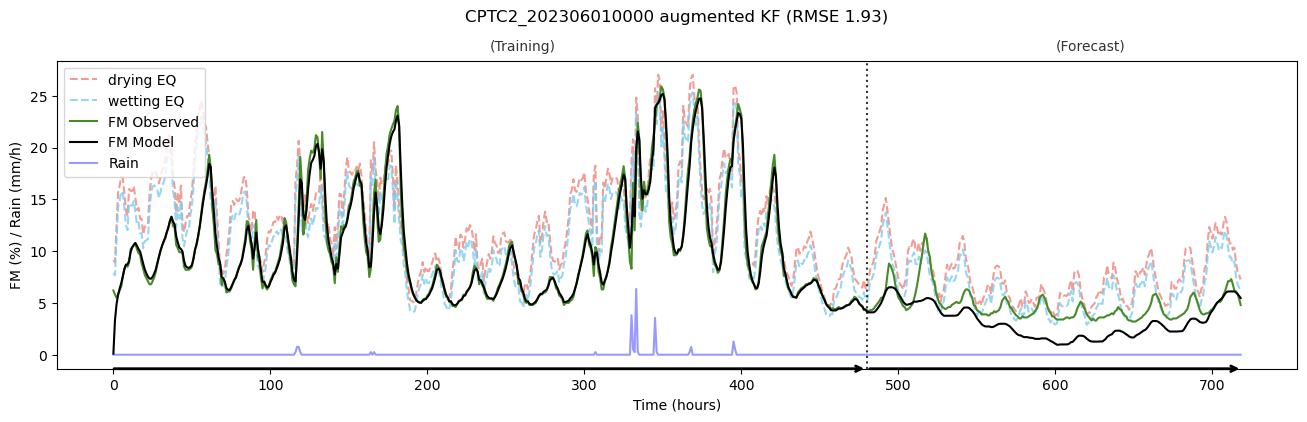

In [4]:
m, Ec =mod.run_augmented_kf(case_data)
case_data["m"] = m
plot_data(case_data,title2='augmented KF')

The Augmented KF is reasonable.

### Linear Activation overestimates

Next, we initialize the RNN with linear activation and 1 single hidden unit and plot.

In [5]:
# Linear Activation Params
params={'id':1,
        'purpose':'test 1',
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['linear','linear'],
        'hidden_units':1,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[0.0,0.0],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':1000,
        'verbose_fit':False,
        'verbose_weights':False,
}

In [6]:
reproducibility.set_seed() # Set seed for reproducibility
rnn_dat = create_rnn_data(case_data,params)
model1 = train_rnn(
    rnn_dat,
    params,
    rnn_dat['hours'],
    fit=False
)
case_data['m'] = rnn_predict(model1, params, rnn_dat)
fit_linear = case_data['m']

resetting random seeds to 123
scaling to range 0 to 1
Fitting skipped, using initial weights


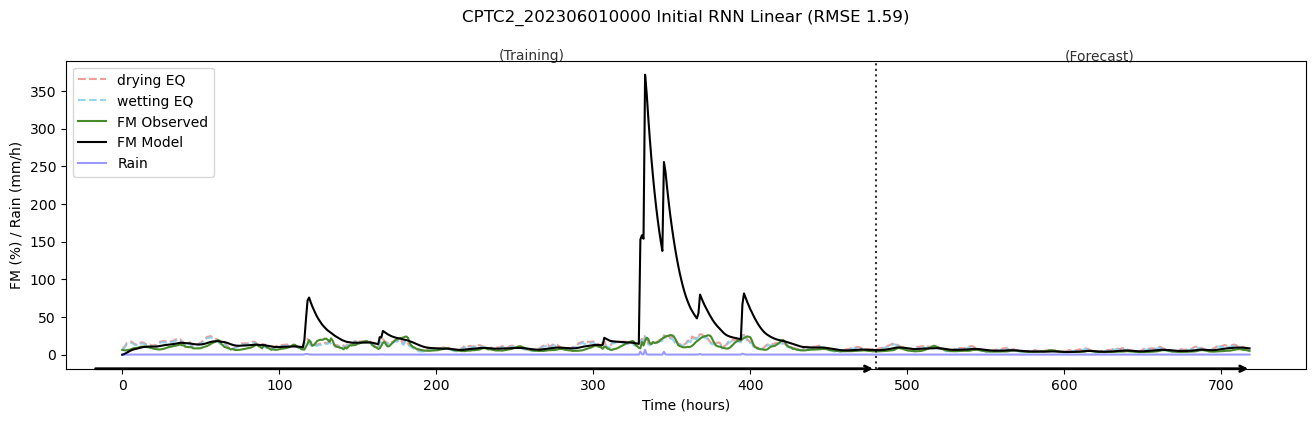

In [7]:
plot_data(case_data,title2='Initial RNN Linear')

In [8]:
model1.get_weights()

[array([[0.04758129],
        [0.04758129],
        [8.513356  ]], dtype=float32),
 array([[0.9048374]], dtype=float32),
 array([0.], dtype=float32),
 array([[1.]], dtype=float32),
 array([-0.03699606], dtype=float32)]

Try again with different `fm_raise_vs_rain`...

In [9]:
# Linear Activation Params
params={'id':1,
        'purpose':'test 1',
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['linear','linear'],
        'hidden_units':1,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[0.0,0.0],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 0.1,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':1000,
        'verbose_fit':False,
        'verbose_weights':False,
}

resetting random seeds to 123
scaling to range 0 to 1
Fitting skipped, using initial weights


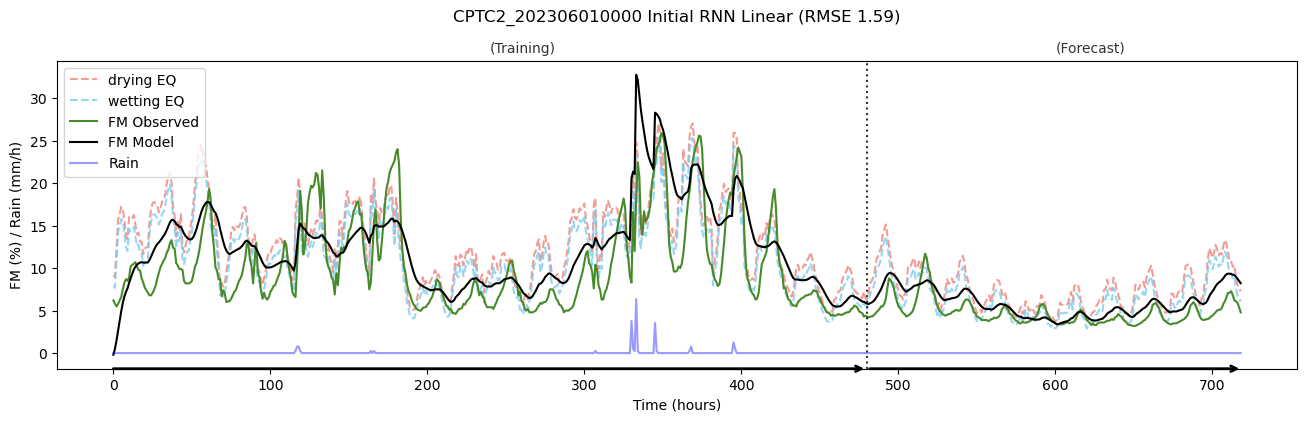

In [10]:
reproducibility.set_seed() # Set seed for reproducibility
rnn_dat = create_rnn_data(case_data,params)
model2 = train_rnn(
    rnn_dat,
    params,
    rnn_dat['hours'],
    fit=False
)
case_data['m'] = rnn_predict(model2, params, rnn_dat)
plot_data(case_data,title2='Initial RNN Linear')

In [11]:
model2.get_weights()

[array([[0.04758129],
        [0.04758129],
        [0.4256678 ]], dtype=float32),
 array([[0.9048374]], dtype=float32),
 array([0.], dtype=float32),
 array([[1.]], dtype=float32),
 array([-0.03699606], dtype=float32)]

The fit is much better. The only initial weight that changed is the 3rd weight in the input layer, which corresponds to rain.

Note that .1 inches is about 2.5 mm, so this looks like a units issue.

Documentation for MesoWest / Mesonet is inconsistent as to whether precipitation is in units of mm or inches:
* [Weather.gov](https://www.weather.gov/media/wrh/mesowest/MesoWest_Data_Variables_Definitions.pdf) says inches
* [Synoptic](https://developers.synopticdata.com/mesonet/v2/api-variables/) says mm.

We investiage the input data and compare rainfall to historical accounts to see if we can deduce inches vs mm:

In [12]:
print(f"RAWS Site {case_data['STID']} lat/lon: {case_data['lat']},{case_data['lon']}")

RAWS Site CPTC2 lat/lon: 38.459440,-109.046940


[0.    0.    0.    0.    0.    0.    0.    3.81  0.508 0.254 6.35  0.254
 0.    0.    0.    0.    0.    0.    0.    0.   ]
['2023-06-14T11:09:00Z' '2023-06-14T12:09:00Z' '2023-06-14T13:09:00Z'
 '2023-06-14T14:09:00Z' '2023-06-14T15:09:00Z' '2023-06-14T16:09:00Z'
 '2023-06-14T17:09:00Z' '2023-06-14T18:09:00Z' '2023-06-14T19:09:00Z'
 '2023-06-14T20:09:00Z' '2023-06-14T21:09:00Z' '2023-06-14T22:09:00Z'
 '2023-06-14T23:09:00Z' '2023-06-15T00:09:00Z' '2023-06-15T01:09:00Z'
 '2023-06-15T02:09:00Z' '2023-06-15T03:09:00Z' '2023-06-15T04:09:00Z'
 '2023-06-15T05:09:00Z' '2023-06-15T06:09:00Z']


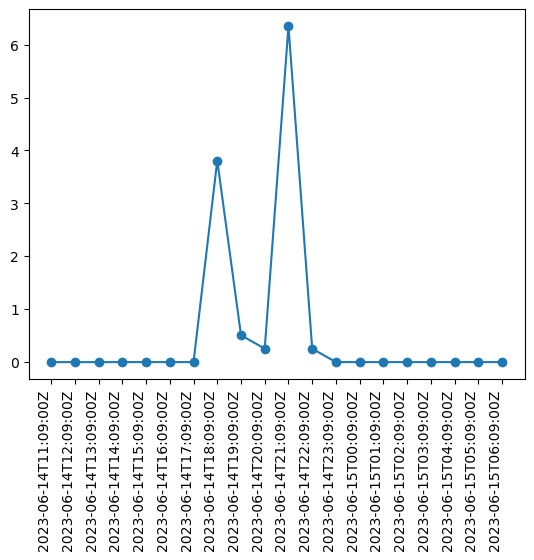

In [13]:
# Get index of largest rainfall and plot series about it with times
ind = case_data['rain'].argmax()
x=case_data['rain'][np.max([ind-10, 0]) : np.min([ind+10, len(case_data['rain'])])]
dates = case_data['time'][np.max([ind-10, 0]) : np.min([ind+10, len(case_data['rain'])])]
plt.plot(dates, x, 'o-')
plt.xticks(rotation=90, ha='right')
print(x)
print(dates)

A quick historical weather search says the max rainfall at this location was roughly 5mm: https://open-meteo.com/en/docs/historical-weather-api#start_date=2023-06-14&end_date=2023-06-15&hourly=rain&daily=&timezone=GMT

Investigating the output from `MesoPy` (from notebook create_RAWS_dict.ipynb), it says the units are mm. So units might not be the issue.

The initial weight is set by multiplying the parameter of fm increase per mm rain by the scaled max fm divided by the scaled max rain, so maybe this could be address with scaling.

### Overestimate issues with other activations

In [14]:
# Tanh Activation Params
params={'id':1,
        'purpose':'test 1',
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['tanh','tanh'],
        'hidden_units':1,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[0.0,0.0],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':1000,
        'verbose_fit':False,
        'verbose_weights':False,
}

resetting random seeds to 123
scaling to range 0 to 1
Fitting skipped, using initial weights


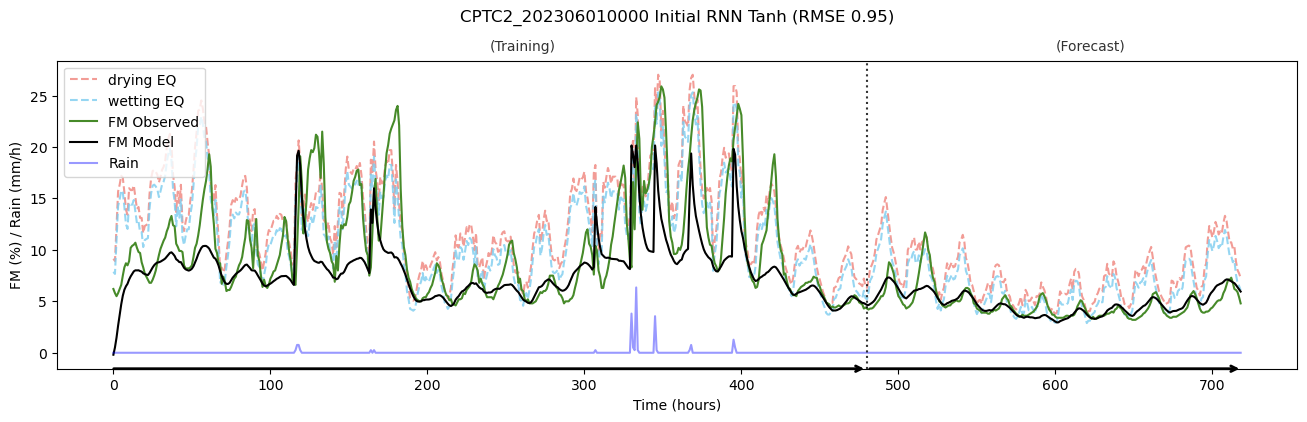

In [15]:
reproducibility.set_seed() # Set seed for reproducibility
rnn_dat = create_rnn_data(case_data,params)
model3 = train_rnn(
    rnn_dat,
    params,
    rnn_dat['hours'],
    fit=False
)
case_data['m'] = rnn_predict(model3, params, rnn_dat)
fit_tanh = case_data['m']
plot_data(case_data,title2='Initial RNN Tanh')

In [16]:
model3.get_weights()

[array([[0.04758129],
        [0.04758129],
        [8.513356  ]], dtype=float32),
 array([[0.9048374]], dtype=float32),
 array([0.], dtype=float32),
 array([[1.]], dtype=float32),
 array([-0.03699606], dtype=float32)]

The overestimation is no longer present with only changing the activation. The initial weight for rain did not have the dramatic effect seen before.

We will reproduce some of the calculations manually below to understand the issue. The hidden state at `t=0` is initialized to `0` (according to ChatGPT, Jan, and other internet sources)

In [17]:
# First model value
print("~"*50)
print(f"Linear Model at t=0: {fit_linear[0]}")
print(f"Tanh Model at t=0: {fit_tanh[0]}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Linear Model at t=0: -0.19019551575183868
Tanh Model at t=0: -0.19043470919132233


In [18]:
weights=model3.get_weights() # Same for both tanh and linear activation
data0 = rnn_dat['Et'][0] # Input data at time 0

#print(data0[0]*weights[0][0] + data0[1]*weights[0][1] + data0[2]*weights[0][2]) # handcalc
#print(np.dot(data0, weights[0])) # with linalg 

# Dot prod is initial weights 
# initial state is 0 times weight 1
# weight2 is 0 bias at RNN layer
# Add em up because of linear activation
# weights 3 is weight into the Dense layer, initialized at 1
# weight 4 is final bias
# Times scale at end
print(
    f"Linear: {((np.dot(data0, weights[0]) + 0*weights[1] + weights[2])*weights[3] + weights[4])*rnn_dat['scale_fm']}"
) 

# Repeat with tanh, same steps except tanh function instead of adding (Linear)
foo = model3.get_layer(model3.layers[1].name).activation # extract activation function

print(
    f"Tanh: {(foo(np.dot(data0, weights[0]) + 0*weights[1] + weights[2])*weights[3] + weights[4])*rnn_dat['scale_fm']}"
) 

Linear: [[-0.19019549]]
Tanh: [[-0.19043769]]


The output is the same to about 7 decimal places.

Next we show how blowup happens with linear activation. Currently, tanh activation feeds into a dense unit with weight 1, so for 1 initialized RNN cell the final dense layer does not change the output. The calculation above used the inputs at time zero, which had zero rain. Consider the same calculation for a range of rain values, from 0 to 6, the max observed in the case data

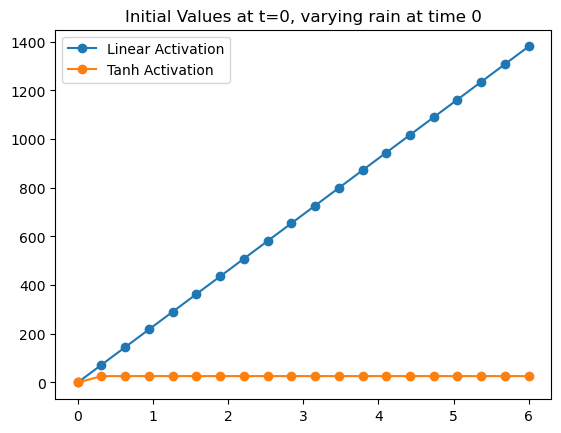

In [19]:
data0 = rnn_dat['Et'][0]
x = np.linspace(0, 6, 20)
y_lin = np.zeros(20)
y_tanh = np.zeros(20)

for i in range(0, 20):
    data0[2] = x[i]
    y_lin[i]=((np.dot(data0, weights[0]) + 0*weights[1] + weights[2])*weights[3] + weights[4])*rnn_dat['scale_fm']
    y_tanh[i]=(foo(np.dot(data0, weights[0]) + 0*weights[1] + weights[2])*weights[3] + weights[4])*rnn_dat['scale_fm']

plt.plot(x, y_lin, '-o', label="Linear Activation")
plt.plot(x, y_tanh, '-o', label="Tanh Activation")
plt.title("Initial Values at t=0, varying rain at time 0")
plt.legend()

### Discussion of Initial Fit Overestimation

Is 2 % fm increase per mm of rain simply too much? Is threshold rainfall accounted for? 

The tanh activation avoids blow up effect of rain, but not due to physically reasonable processes.

### Sigmoid Underestimating in initial fit

* Case study: `CPTC2_202306010000`, `CHRC2_202306010000` with sigmoid activation

Note first was a case study for overfitting with linear activation.

In [20]:
# Sigmoid Activation Params
params={'id':1,
        'purpose':'test 1',
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['sigmoid','sigmoid'],
        'hidden_units':1,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[0.5,0.5],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':1000,
        'verbose_fit':False,
        'verbose_weights':False,
}

resetting random seeds to 123
scaling to range 0 to 1
Fitting skipped, using initial weights


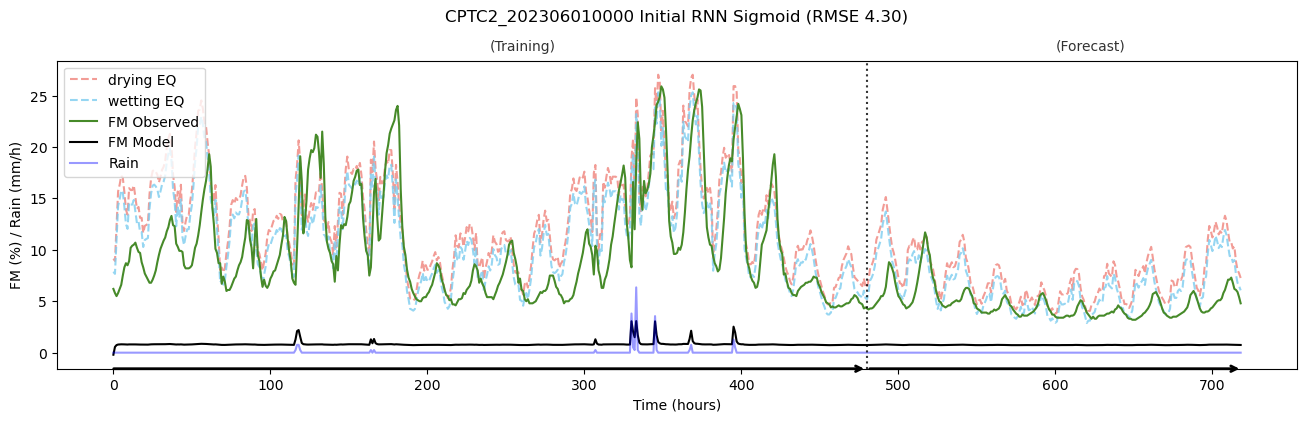

In [21]:
reproducibility.set_seed() # Set seed for reproducibility
id = "CPTC2_202306010000"
case_data=test_dict[id]
rnn_dat = create_rnn_data(case_data,params)
model_predict = train_rnn(
    rnn_dat,
    params,
    rnn_dat['hours'],
    fit=False
)
case_data['m'] = rnn_predict(model_predict, params, rnn_dat)
plot_data(case_data,title2='Initial RNN Sigmoid')

In [22]:
model_predict.get_weights()

[array([[0.04758129],
        [0.04758129],
        [8.513356  ]], dtype=float32),
 array([[0.9048374]], dtype=float32),
 array([0.], dtype=float32),
 array([[1.]], dtype=float32),
 array([-0.53699607], dtype=float32)]

The initial weights are the same as before except the final bias term, since that is affected by the centering needed to get the sigmoid function approximately linear on initialization.

Decreasing centering...

Fitting skipped, using initial weights


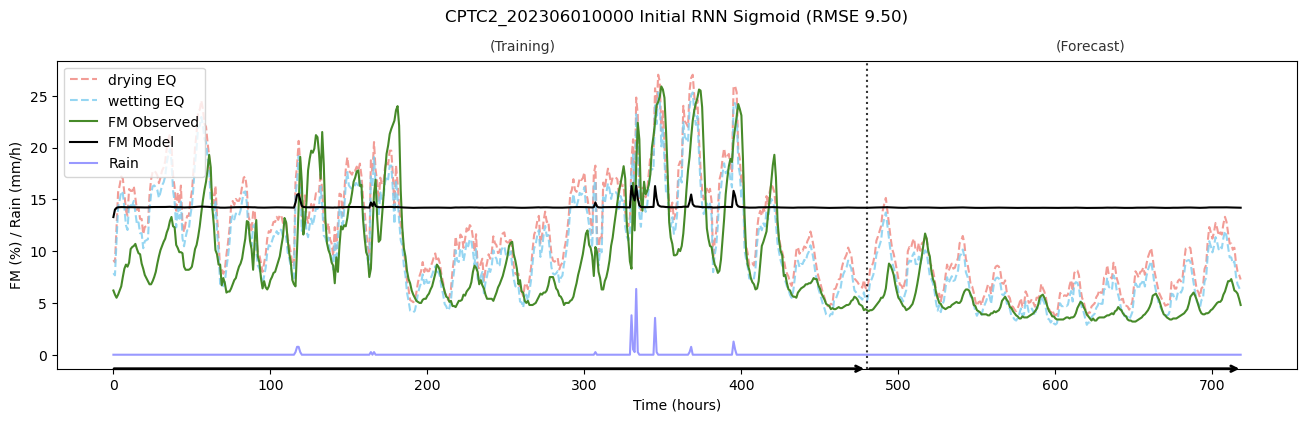

In [23]:
# Sigmoid Activation Params
params={'id':1,
        'purpose':'test 1',
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['sigmoid','sigmoid'],
        'hidden_units':1,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[.1,.1],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':1000,
        'verbose_fit':False,
        'verbose_weights':False,
}
model_predict = train_rnn(
    rnn_dat,
    params,
    rnn_dat['hours'],
    fit=False
)
case_data['m'] = rnn_predict(model_predict, params, rnn_dat)
plot_data(case_data,title2='Initial RNN Sigmoid')

The initial fit is dominated by the rain events, and essentially flat everywhere else. The initialization for sigmoid is failing.

In [24]:
# Manually work with activation function

model_predict.layers[1].activation

<function keras.src.activations.sigmoid(x)>

## Clipping Issues

Some fitted RNN models "clip" the model, where values don't go above or below a certain threshold.

* Clipped Below case study: `TT590_202306010000` with tanh activation
* Clipped Above case study: `CHRC2_202306010000`, `LKGC2_202306010000` with sigmoid

Seems to correspond with underestimation initial fits.